In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import pickle
import pandas as pd
from torch import nn
# sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import axes, bundles
###
from ml_utilities.torch_models.fc import FC
from ml_utilities.output_loader.model_loader import load_model_from_idx, load_directions_matrix_from_task_sweep, load_multiple_dir_matrices_from_sweep
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from erank.plot import plot_models_erank
from erank.analyses import create_model_erank_df

In [2]:
gpu_id = 0

# 11.6.1 MNIST Conv4 rotatedtasks

In [3]:
# experiment config + output directory
output_dir = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.6.1-conv4_rotatedtasks--221104_082910'
pretrain_dir = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.4.0-conv4--221015_122409'

## A. Pretrain run

In [4]:
jobpr = JobResult(pretrain_dir)
jobpr.is_successful_job, jobpr.override_hpparams, jobpr.data_log_sources, jobpr.progress_measure, jobpr.best_model_idx

(True, {}, ['train_step', 'train', 'val'], 'step', 480)

In [5]:
jobpr.get_summary()

,best_step,best_val_score,seed
mnist-11.4.0-conv4--221015_122409,480,0.986583,0


In [6]:
prdf = jobpr.get_data_log('train')
prdf

,log_step,epoch,train_step,loss_CrossEntropyLoss,Accuracy,time_last_train_epoch_in_s
0,413,1,375,0.163823,0.955104,0.000000
1,552,2,500,0.086634,0.981313,107.591312


In [7]:
prdf = jobpr.get_data_log(['train_step', 'val'])
prdf

,log_step,epoch,train_step,train_step-loss_CrossEntropyLoss,train_step-Accuracy,train_step-weight_norm,val-loss_CrossEntropyLoss,val-Accuracy,val-time_last_val_epoch_in_s
500,0,0,0,NaN,NaN,NaN,2.301870,0.103667,0.000000
0,1,1,0,2.340212,0.117188,18.655848,NaN,NaN,NaN
1,2,1,1,1.898805,0.375000,18.661373,NaN,NaN,NaN
2,3,1,2,1.534224,0.695312,18.668844,NaN,NaN,NaN
3,4,1,3,1.397871,0.718750,18.677570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
496,547,2,496,0.036047,0.984375,20.195818,NaN,NaN,NaN
497,548,2,497,0.038783,0.984375,20.198223,NaN,NaN,NaN
498,549,2,498,0.035181,0.992188,20.200645,NaN,NaN,NaN
499,550,2,499,0.118217,0.968750,20.202511,NaN,NaN,NaN


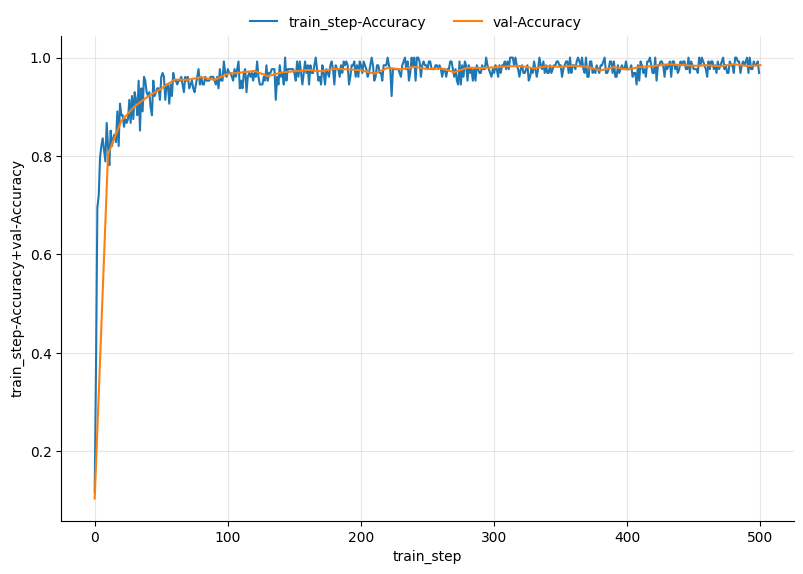

In [11]:
# plot learning curve
f = plot_data_log_values(prdf, x_axis='train_step', y_axis_left=['train_step-Accuracy', 'val-Accuracy'])

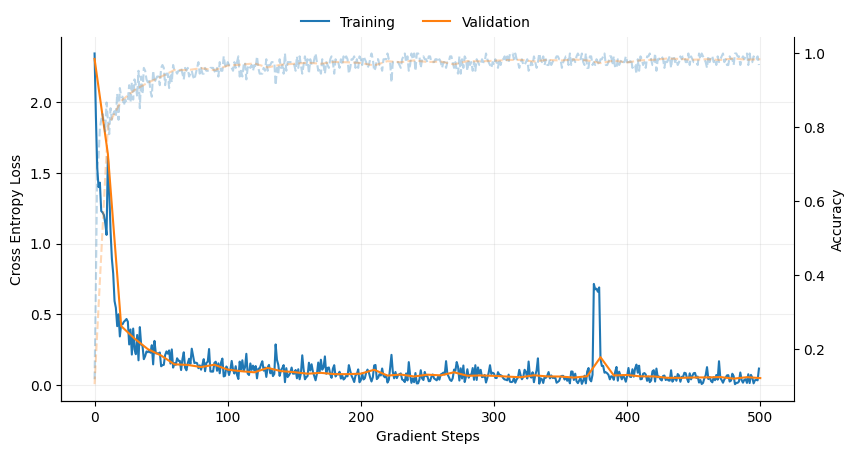

In [12]:
alpha = 0.3
style_dict = {
    'train_step-loss_CrossEntropyLoss': {
        'label': 'Training'
    },
    'val-loss_CrossEntropyLoss': {
        'label': 'Validation'
    },
    'train_step-Accuracy': {
        'label': '',
        'alpha': alpha,
        'ls': '--'
    },
    'val-Accuracy': {
        'label': '',
        'alpha': alpha,
        'ls': '--'
    }
}
with plt.rc_context({}):
    f = plot_data_log_values(prdf,
                             x_axis='train_step',
                             y_axis_left=['train_step-loss_CrossEntropyLoss', 'val-loss_CrossEntropyLoss'],
                             y_axis_right=['train_step-Accuracy', 'val-Accuracy'],
                             y_label_left='Cross Entropy Loss',
                             y_label_right='Accuracy',
                             x_label='Gradient Steps',
                             style_dict=style_dict,
                             grid_alpha=0.2,
                             figsize=(2 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54))


## B. Sweep

In [13]:
sweepr = SweepResult(output_dir)
sweepr.sweep_params, sweepr.get_failed_jobs()

100%|██████████| 2520/2520 [00:40<00:00, 61.96it/s]


(['trainer.init_model_step', 'data.dataset_kwargs.rotation_angle'], [])

In [14]:
print(OmegaConf.to_yaml(sweepr.sweep_dict))

type: grid
axes:
- parameter: trainer.init_model_step
  vals:
  - 0
  - 5
  - 10
  - 20
  - 50
  - 100
  - 480
- parameter: data.dataset_kwargs.rotation_angle
  vals: linspace(0,180,360,endpoint=True)



In [15]:
init_model_step_vals = [0, 5, 10, 100, 480]
row_sel_train_steps = [0, 5, 10, 30, 100, 500]

In [16]:
sdf = sweepr.get_summary(log_source='val', row_sel=('train_step', row_sel_train_steps), col_sel=['Accuracy'])
sdf

100%|██████████| 2520/2520 [01:13<00:00, 34.07it/s]


,best_step,best_val_score,Accuracy-train_step-0,Accuracy-train_step-5,Accuracy-train_step-10,Accuracy-train_step-30,Accuracy-train_step-100,Accuracy-train_step-500,trainer.init_model_step,data.dataset_kwargs.rotation_angle,seed
mnist-11.6.1-conv4_rotatedtasks--init_model_step-0-rotation_angle-0.0-seed-0--221105_130621,1095,0.991333,0.103667,0.661167,0.741500,0.886917,0.957000,0.984333,0,0.000000,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-0-rotation_angle-0.5013927576601671-seed-0--221105_020903,1865,0.991250,0.103583,0.675917,0.752917,0.887667,0.957500,0.985000,0,0.501393,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-0-rotation_angle-1.0027855153203342-seed-0--221106_123926,1095,0.991250,0.103417,0.682167,0.754250,0.887500,0.958833,0.985250,0,1.002786,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-0-rotation_angle-1.5041782729805013-seed-0--221105_013616,1510,0.991167,0.103167,0.690167,0.748167,0.887500,0.957833,0.984167,0,1.504178,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-0-rotation_angle-10.027855153203342-seed-0--221106_133212,1510,0.991750,0.103500,0.655167,0.727750,0.875583,0.957000,0.985417,0,10.027855,0
...,...,...,...,...,...,...,...,...,...,...,...
mnist-11.6.1-conv4_rotatedtasks--init_model_step-50-rotation_angle-97.77158774373258-seed-0--221104_165004,1895,0.991500,0.162250,0.593167,0.825167,0.922500,0.968417,0.983000,50,97.771588,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-50-rotation_angle-98.27298050139275-seed-0--221106_065556,1760,0.991667,0.162917,0.597833,0.824583,0.915417,0.969917,0.984000,50,98.272981,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-50-rotation_angle-98.77437325905292-seed-0--221104_230902,1895,0.991750,0.162417,0.596833,0.825417,0.916583,0.971083,0.984417,50,98.774373,0
mnist-11.6.1-conv4_rotatedtasks--init_model_step-50-rotation_angle-99.27576601671309-seed-0--221105_060655,1360,0.991417,0.163000,0.595750,0.825917,0.902167,0.966833,0.985750,50,99.275766,0


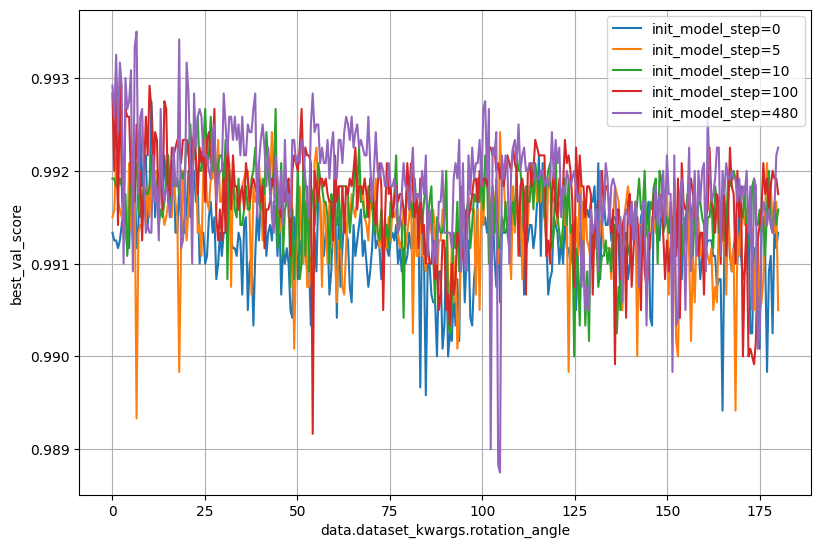

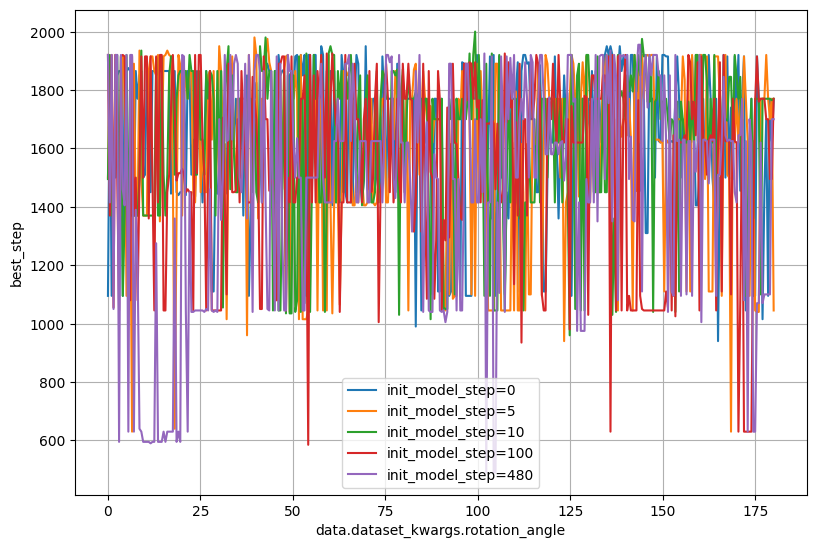

In [17]:
f = plot_sweep_summary(sdf, x_axis='data.dataset_kwargs.rotation_angle', y_axis='best_val_score', compare_parameter='trainer.init_model_step', compare_parameter_val_selection=init_model_step_vals)
f = plot_sweep_summary(sdf, x_axis='data.dataset_kwargs.rotation_angle', y_axis='best_step', compare_parameter='trainer.init_model_step', compare_parameter_val_selection=init_model_step_vals)

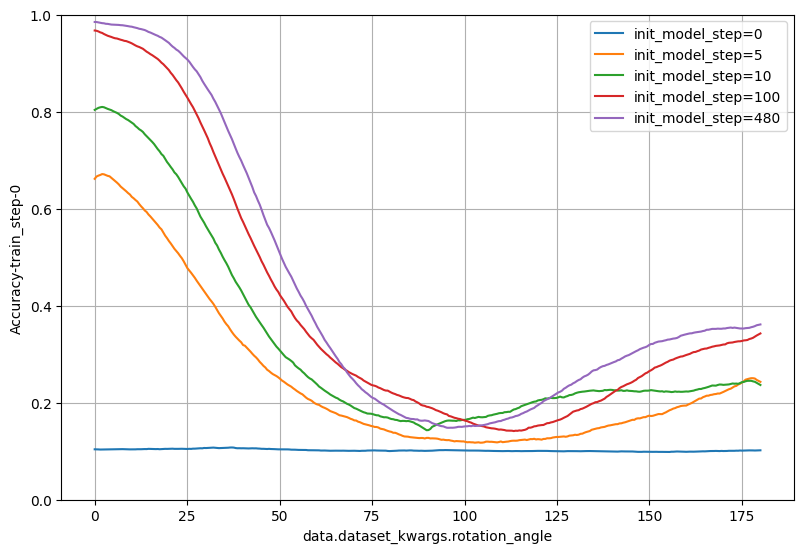

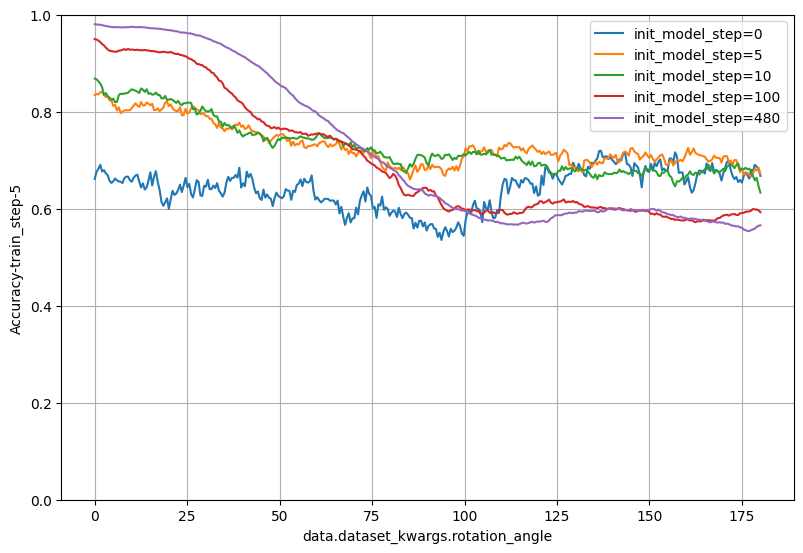

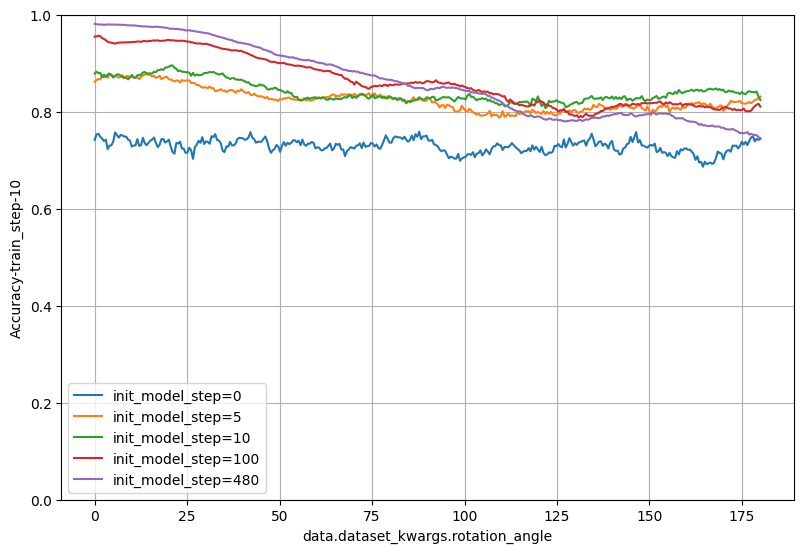

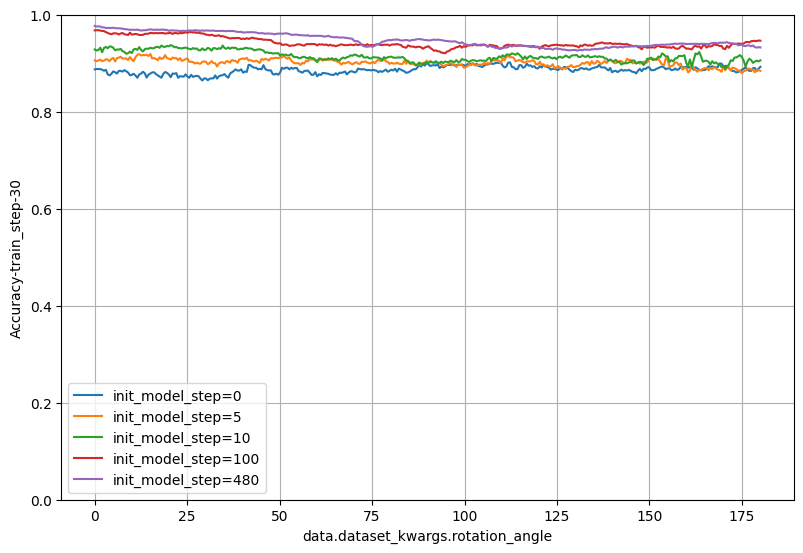

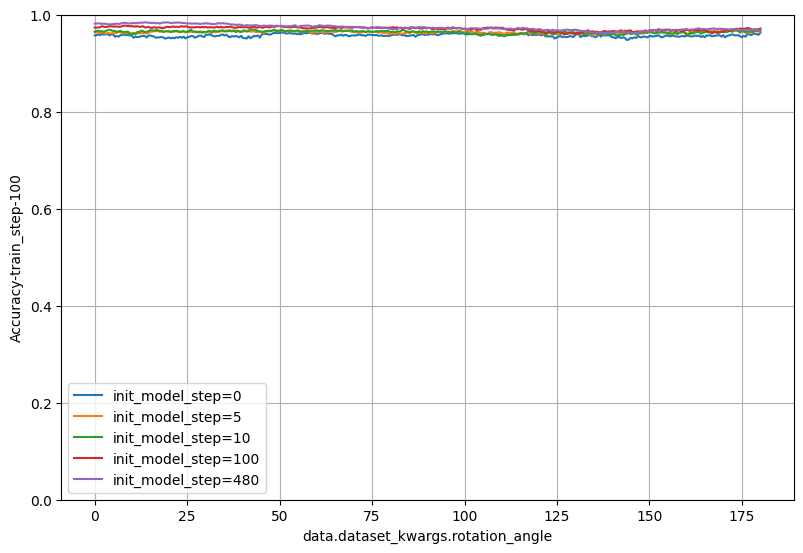

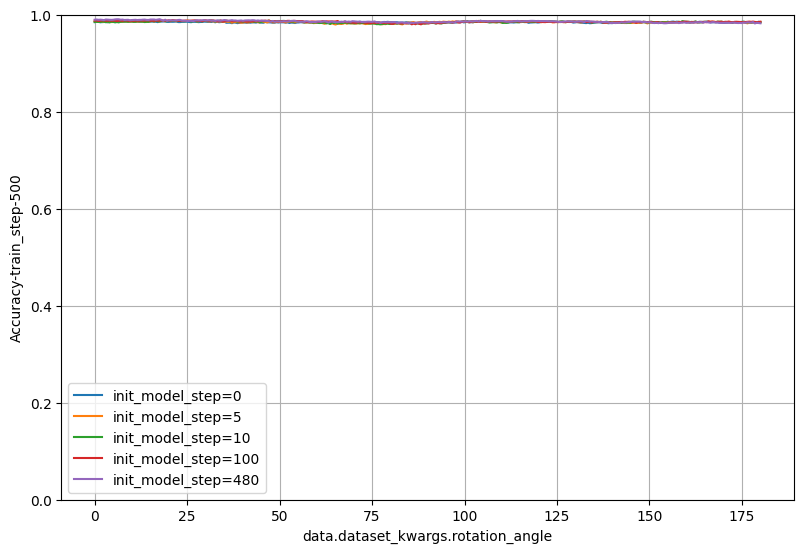

In [18]:
train_steps = row_sel_train_steps
for train_step in row_sel_train_steps:
    f = plot_sweep_summary(sdf, x_axis='data.dataset_kwargs.rotation_angle', y_axis=f'Accuracy-train_step-{train_step}', compare_parameter='trainer.init_model_step', compare_parameter_val_selection=init_model_step_vals, ylim=(0,1.0))

In [19]:
# fig.savefig(f'11_6_mnist_conv4_rotatedtasks_erankplot.png', dpi=300, bbox_inches='tight')